In [7]:
%%capture
!pip install -q imantics
!pip install -q segmentation_models_pytorch

In [8]:
import os
import random
import json

from tqdm import tqdm
import imantics
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import albumentations as A

In [9]:
N_IMAGES = 512
TRAIN_IMAGE_SIZE = 512
INPUT_IMAGE_SIZE = (1920, 1080)

In [10]:
with open("/content/annotations/instances_default.json") as f:
    annotations = json.load(f)

In [11]:
annotations.keys()

dict_keys(['licenses', 'info', 'categories', 'images', 'annotations'])

In [12]:
annotations["images"][0]

{'id': 1,
 'width': 1920,
 'height': 1080,
 'file_name': '0.jpg',
 'license': 0,
 'flickr_url': '',
 'coco_url': '',
 'date_captured': 0}

In [13]:
map_id_filename = {}
for index in range(len(annotations["images"])):
    map_id_filename[annotations["images"][index]["id"]] = annotations["images"][index]["file_name"]

In [14]:
map_id_filename[1]

'0.jpg'

In [15]:
images = np.zeros((N_IMAGES, TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE, 3), dtype=np.uint8)

for image_id, image_filename in map_id_filename.items():
    cur_image = cv2.imread(f"/content/images/{image_filename}")
    cur_image = cv2.cvtColor(cur_image, cv2.COLOR_BGR2RGB)
    cur_image = cv2.resize(cur_image, (TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE))

    images[image_id - 1] = cur_image

In [16]:
masks = np.zeros((N_IMAGES, TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE), dtype=bool)

for index in range(len(annotations["annotations"])):
    image_id = annotations["annotations"][index]["image_id"]
    segmentation = annotations["annotations"][index]["segmentation"]

    cur_mask = imantics.Polygons(segmentation).mask(*INPUT_IMAGE_SIZE).array
    cur_mask = cv2.resize(cur_mask.astype(float), (TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE)) >= 0.5

    masks[image_id - 1] = masks[image_id - 1] | cur_mask

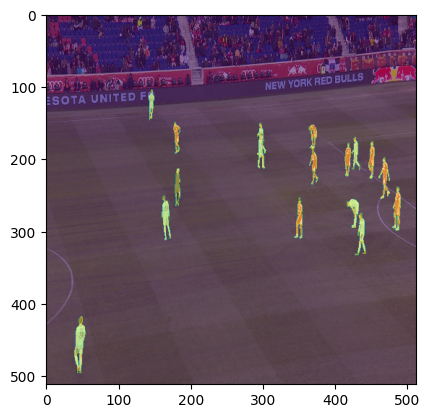

In [17]:
plt.imshow(images[0])
plt.imshow(masks[0], alpha=0.5)

In [18]:
class CFG:
    seed = 42
    train_size = 0.8
    batch_size = 4
    lr = 0.001
    n_epochs = 5
    device = "cuda"

In [19]:
def seed_everything(seed: int) -> None:
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(CFG.seed)

In [20]:
indexes = list(range(N_IMAGES))
train_indexes = indexes[: int(N_IMAGES * CFG.train_size)]
valid_indexes = indexes[int(N_IMAGES * CFG.train_size) :]

In [21]:
def get_transforms():
    return A.Compose(
        [
            A.HueSaturationValue( # Change colors
                p=1.0,
                hue_shift_limit=(-20, 20),
                sat_shift_limit=(-30, 30),
                val_shift_limit=(-20, 20),
            ),
            A.HorizontalFlip(p=0.5),
        ],
        p=1.0
    )

In [22]:
class CustomDataset(Dataset):
    def __init__(self, indexes, transform=None, preprocess=None):
        self.indexes = indexes
        self.transform = transform
        self.preprocess = preprocess

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, index):
        _index = self.indexes[index]

        image = images[_index]
        mask = masks[_index]

        if self.transform:
            data = {"image": image, "mask": mask}
            augmented = self.transform(**data)
            image, mask = augmented["image"], augmented["mask"]

        if self.preprocess:
            image = self.preprocess(image)

        image = torch.tensor(image, dtype=torch.float)
        mask = torch.tensor(mask, dtype=torch.float)

        image = image.permute(2, 0, 1)
        mask = mask.unsqueeze(0)

        return {"image": image, "mask": mask}

In [23]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 336MB/s]


In [24]:
preprocess_input = get_preprocessing_fn("resnet34", pretrained="imagenet")

In [25]:
train_dataset = CustomDataset(
    train_indexes, transform=get_transforms(), preprocess=preprocess_input
)
train_dataloader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)

valid_dataset = CustomDataset(valid_indexes, preprocess=preprocess_input)
valid_dataloader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False)

In [26]:
model.to(CFG.device)

criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=CFG.lr)

In [27]:
def iou(outputs, labels) -> float:
    intersection = np.sum(np.logical_and(outputs, labels), axis=(1, 2, 3))
    union = np.sum(np.logical_or(outputs, labels), axis=(1, 2, 3))
    iou = intersection / union
    return np.mean(iou)

In [28]:
train_loss_history = []
val_loss_history = []
train_iou_history = []
val_iou_history = []

for epoch in range(CFG.n_epochs):
    train_loss = 0
    train_iou = 0
    model.train()
    for i, batch in tqdm(enumerate(train_dataloader)):
        inputs = batch["image"].to(CFG.device)
        labels = batch["mask"].to(CFG.device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        _iou = iou(outputs.detach().cpu().numpy() >= 0, labels.detach().cpu().numpy())
        train_iou += _iou

    train_loss /= len(train_dataloader)
    train_iou /= len(train_dataloader)
    train_loss_history.append(train_loss)
    train_iou_history.append(train_iou)

    val_loss = 0
    val_iou = 0
    model.eval()
    with torch.no_grad():
        for i, batch in tqdm(enumerate(valid_dataloader)):
            inputs = batch["image"].to(CFG.device)
            labels = batch["mask"].to(CFG.device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _iou = iou(outputs.detach().cpu().numpy() >= 0, labels.detach().cpu().numpy())
            val_iou += _iou

    val_loss /= len(valid_dataloader)
    val_iou /= len(valid_dataloader)
    val_loss_history.append(val_loss)
    val_iou_history.append(val_iou)

    print(
        "Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Train IOU: {:.4f}, Val IOU: {:.4f}".format(
            epoch + 1, CFG.n_epochs, train_loss, val_loss, train_iou, val_iou
        )
    )

103it [00:31,  3.27it/s]
26it [00:03,  8.58it/s]


Epoch [1/5], Train Loss: 0.1780, Val Loss: 0.0365, Train IOU: 0.6080, Val IOU: 0.7371


103it [00:30,  3.36it/s]
26it [00:02, 10.02it/s]


Epoch [2/5], Train Loss: 0.0238, Val Loss: 0.0160, Train IOU: 0.7910, Val IOU: 0.8182


103it [00:30,  3.35it/s]
26it [00:02,  9.62it/s]


Epoch [3/5], Train Loss: 0.0138, Val Loss: 0.0107, Train IOU: 0.8261, Val IOU: 0.8464


103it [00:30,  3.40it/s]
26it [00:02,  8.79it/s]


Epoch [4/5], Train Loss: 0.0108, Val Loss: 0.0091, Train IOU: 0.8380, Val IOU: 0.8555


103it [00:30,  3.37it/s]
26it [00:02,  9.59it/s]

Epoch [5/5], Train Loss: 0.0090, Val Loss: 0.0077, Train IOU: 0.8523, Val IOU: 0.8681


In [29]:
torch.save(
    {
        "model_state_dict": model.state_dict(),
    },
    "last_model.pt",
)

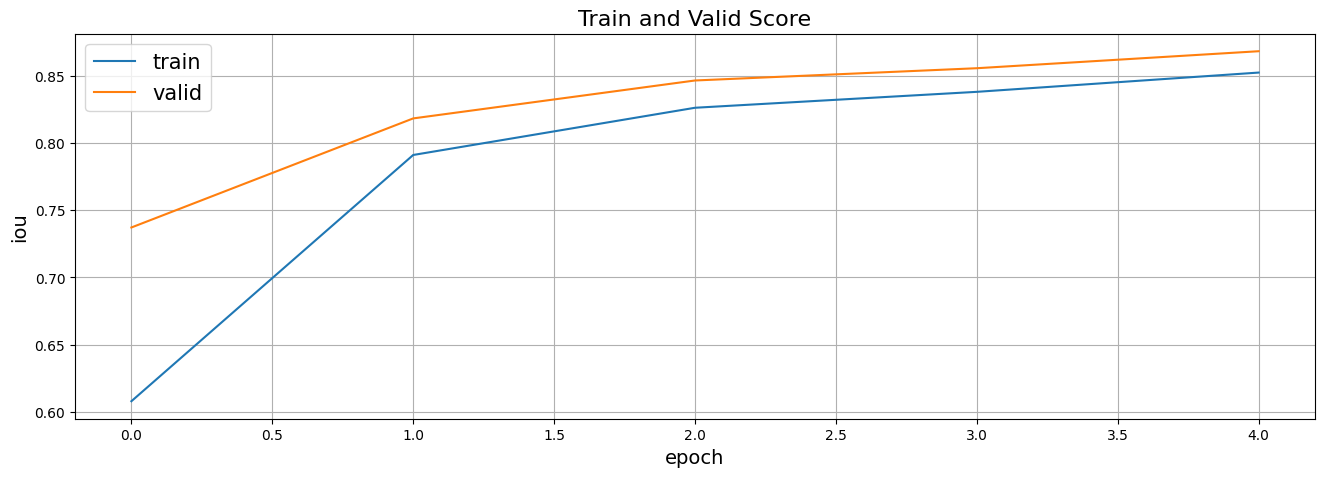

In [30]:
plt.figure(figsize=(16, 5))
plt.plot(range(CFG.n_epochs), train_iou_history, label="train")
plt.plot(range(CFG.n_epochs), val_iou_history, label="valid")

plt.title("Train and Valid Score", fontsize=16)
plt.legend(fontsize=15)
plt.ylabel("iou", fontsize=14)
plt.xlabel("epoch", fontsize=14)
plt.grid()
plt.show()

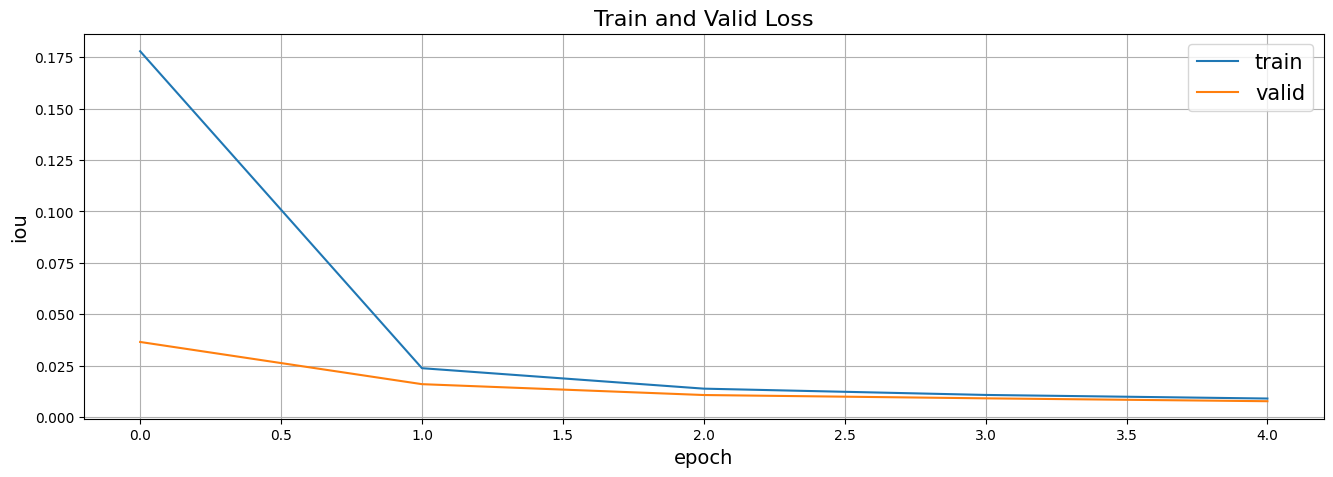

In [31]:
plt.figure(figsize=(16, 5))
plt.plot(range(CFG.n_epochs), train_loss_history, label="train")
plt.plot(range(CFG.n_epochs), val_loss_history, label="valid")

plt.title("Train and Valid Loss", fontsize=16)
plt.legend(fontsize=15)
plt.ylabel("iou", fontsize=14)
plt.xlabel("epoch", fontsize=14)
plt.grid()
plt.show()

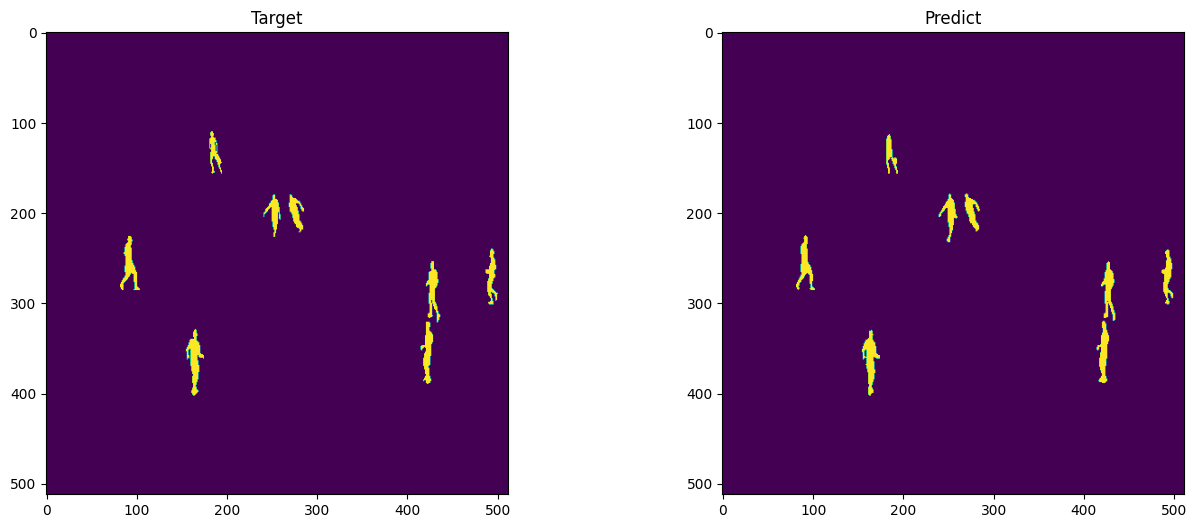

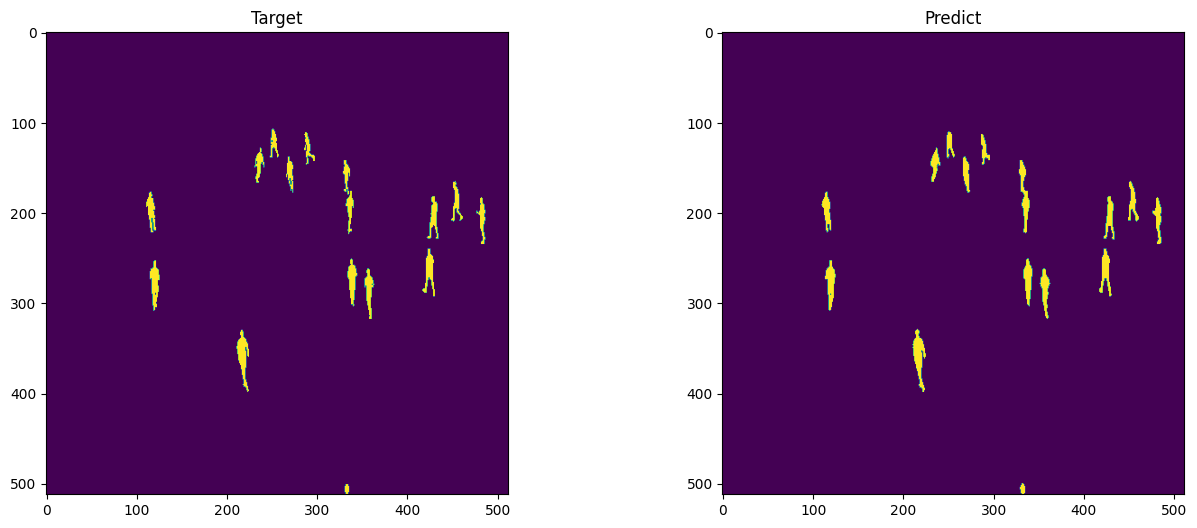

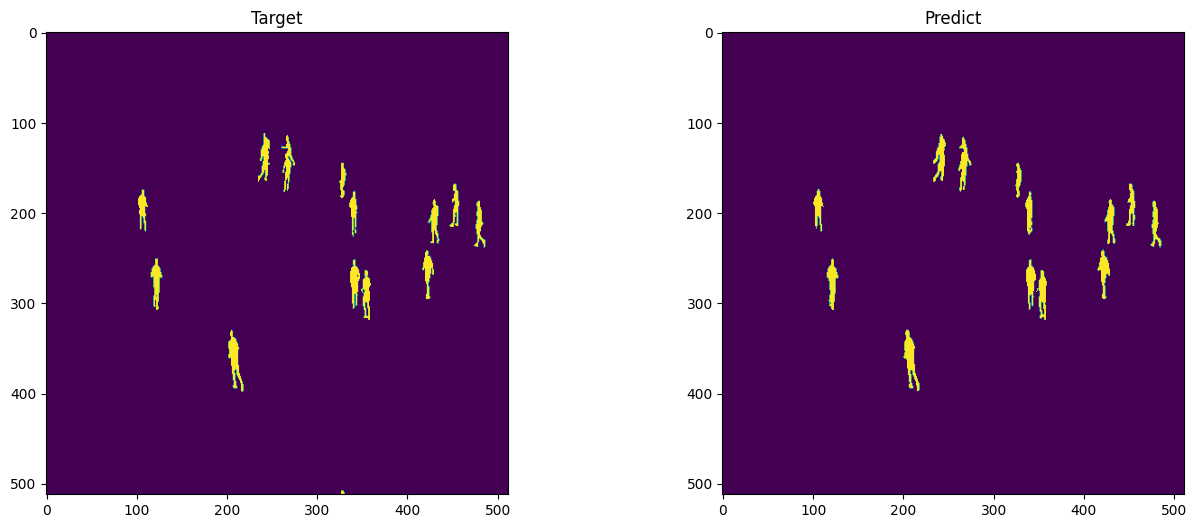

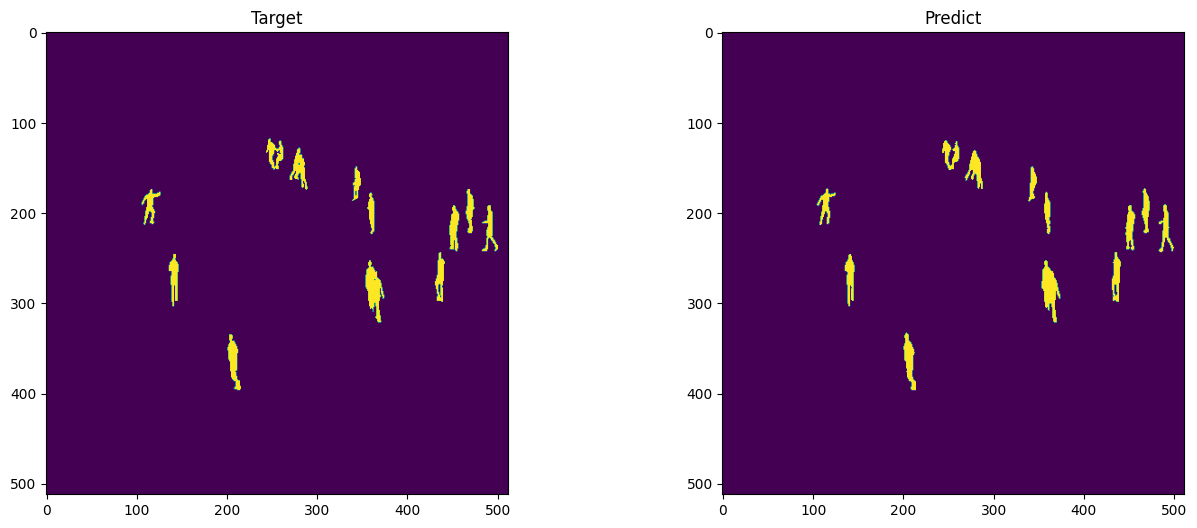

In [32]:
with torch.no_grad():
    for i, batch in enumerate(valid_dataloader):
        inputs = batch["image"].to(CFG.device)
        labels = batch["mask"].to(CFG.device)

        outputs = model(inputs)

        np_labels = labels.detach().cpu().numpy()
        np_outputs = outputs.detach().cpu().numpy()

        for i in range(len(np_labels)):
            plt.figure(figsize=(16, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(np_labels[i][0])
            plt.title("Target")
            plt.subplot(1, 2, 2)
            plt.imshow(np_outputs[i][0] >= 0)
            plt.title("Predict")
            plt.show()

        break

In [33]:
saved_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

In [34]:
state_dict=torch.load("/content/last_model.pt")
saved_model.load_state_dict(state_dict["model_state_dict"])

<All keys matched successfully>

In [ ]:
saved_model.to(CFG.device)

In [42]:
def predict_segment(image_size,image_path):
  cur_image = cv2.imread(image_path)
  cur_image = cv2.cvtColor(cur_image, cv2.COLOR_BGR2RGB)
  cur_image = cv2.resize(cur_image, (image_size, image_size))

  image = torch.tensor(cur_image, dtype=torch.float)
  image = image.permute(2, 0, 1)
  image=image.unsqueeze(0)
  image=image.to(CFG.device)

  with torch.no_grad():
    output=saved_model(image)
    np_outputs = output.detach().cpu().numpy()
    image_data = np_outputs.squeeze()
    image_data=image_data >= 0
    plt.imshow(cur_image[0])
    plt.imshow(image_data)
    plt.colorbar()
    plt.show()

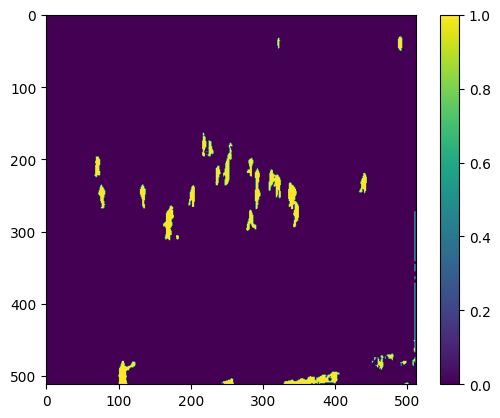

In [43]:
out=predict_segment(512,"/content/football_p1.jpg")

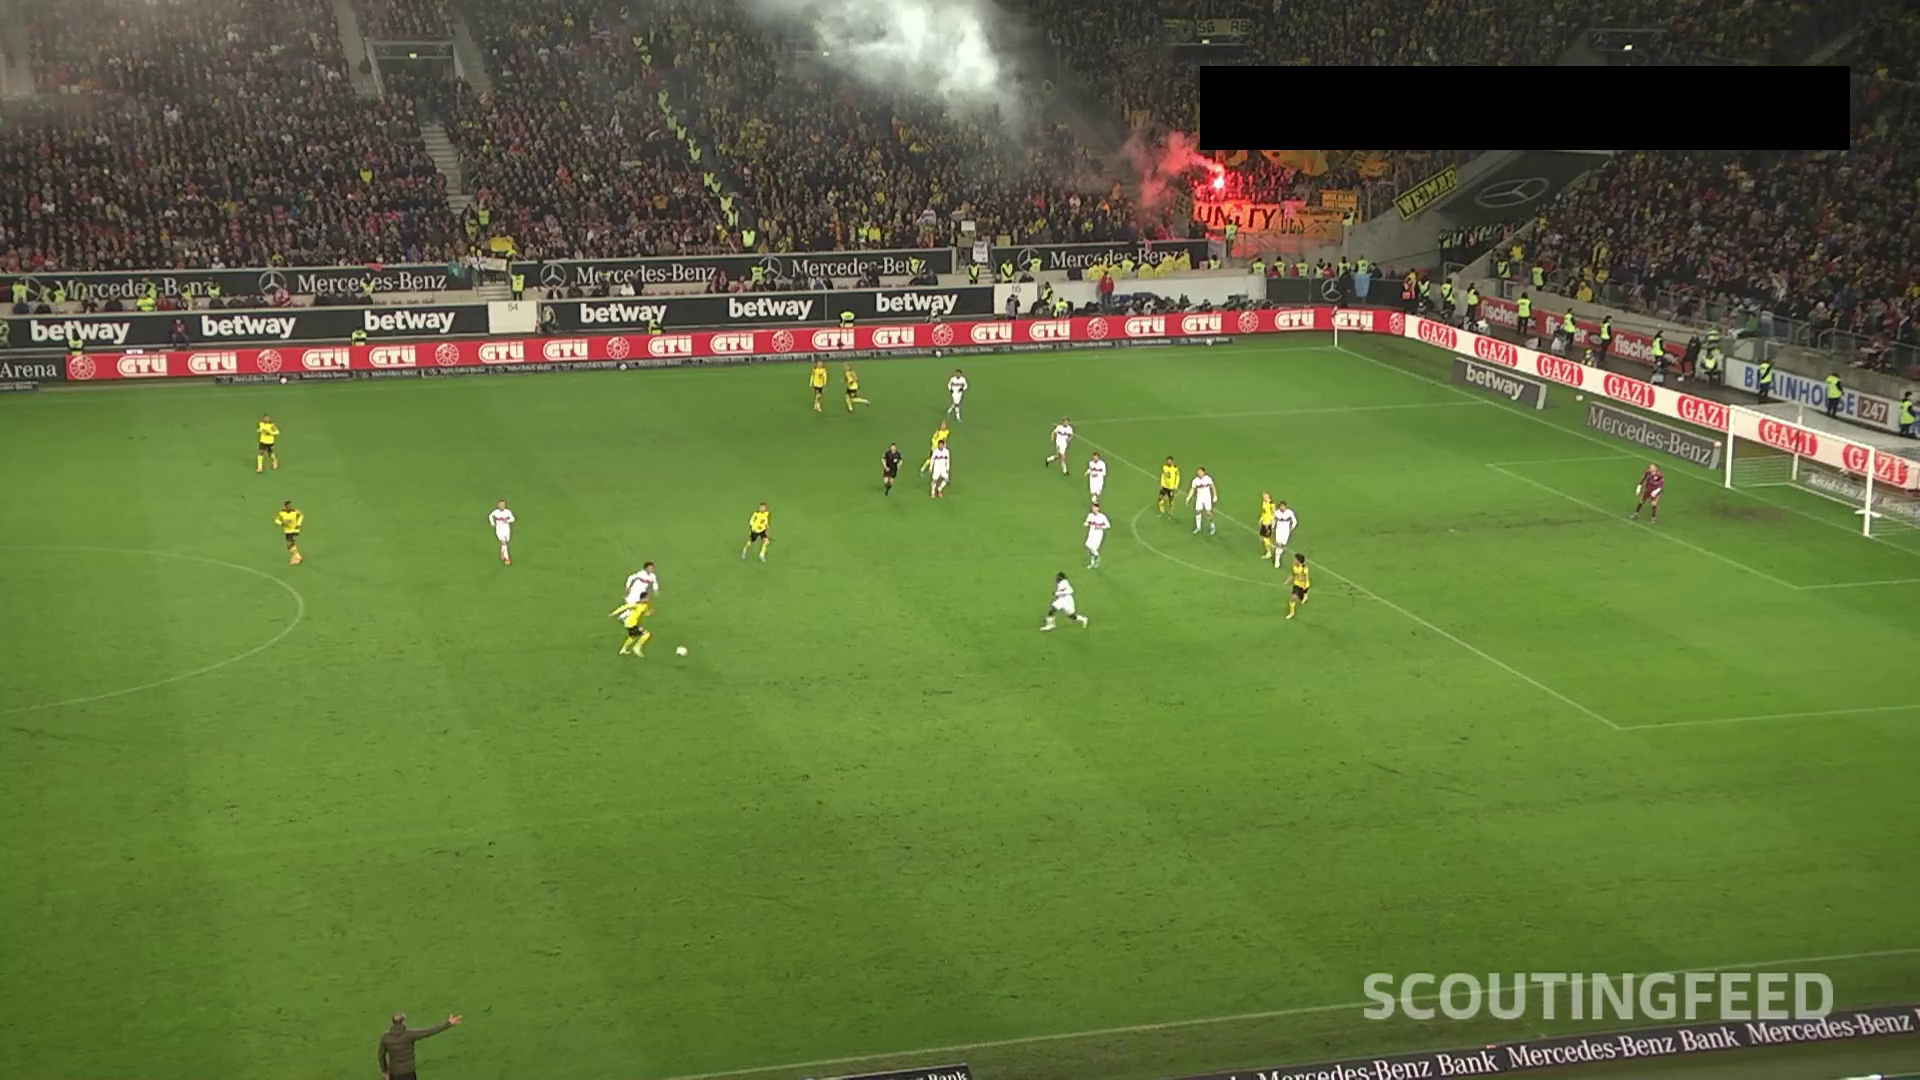

In [41]:
from PIL import Image
Image.open("/content/football_p1.jpg")